In [1]:
import sys, os
os.path.dirname(sys.executable)

'/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/bin'

In [2]:
sys.path.append('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/')
from ESMCBA.imports import *
from ESMCBA import graph_utils
from ESMCBA import other_utils
import importlib
importlib.reload(other_utils)

<module 'ESMCBA.other_utils' from '/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/ESMCBA/other_utils.py'>

In [20]:
def classify(name):
    name_lower = name.lower()
    if 'virus' in name_lower:
        return 'virus'
    elif 'mycobacterium' in name_lower:
        return 'bacterium'
    else:
        return 'other'

# Get all matching CSV files in the folder (here limiting to first 10 for example)
file_list = glob.glob('/global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_*_final.csv')

# Dictionary to store the counts per file
counts_by_file = {}

for file in file_list:
    try:
        # Read file; if empty, skip it.
        df = pd.read_csv(file, header=None)
        if df.empty:
            print(f"Skipping empty file: {file}")
            continue
    except pd.errors.EmptyDataError:
        print(f"Skipping empty file (error): {file}")
        continue

    # Filter rows: Column 7 must not be NA and Column 8 must contain 'Positive'
    df_filtered = df[(df[7].notna()) ] #& (df[8].str.contains('Positive'))]
    
    # Select only HLA allele (column 0) and species name (column 6) then drop duplicates
    df_filtered = df_filtered[[0, 6]].drop_duplicates()
    df_filtered.columns = ['hla', 'name']
    
    # Create a new column with the category classification
    df_filtered['category'] = df_filtered['name'].apply(classify)
    
    # Count the occurrences per category in this file
    category_counts = df_filtered['category'].value_counts()
    
    # Use the basename of the file as the column key
    file_key = os.path.basename(file)
    counts_by_file[file_key] = category_counts

# Combine the counts from all files into a single DataFrame,
# with rows as categories and columns as file names.
aggregated_table = pd.DataFrame(counts_by_file).fillna(0).astype(int)

Skipping empty file (error): /global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLAB5502_final.csv
Skipping empty file (error): /global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLADQ6_final.csv
Skipping empty file (error): /global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLADQA10101DQB10503_final.csv
Skipping empty file (error): /global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLAB0801BI66Amutant_final.csv
Skipping empty file (error): /global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLADRB11305_final.csv
Skipping empty file (error): /global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLADPB11501_final.csv
Skipping empty file (error): /global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLAA0208_final.csv
Skipping empty file (error): /global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLADPB11101_final.csv
Skipping empty file (error): /global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLAA0201K66A,E63Qmutant_final.csv
Skipping empty file (error): /global/scratch/us

In [21]:
aggregated_table.columns = [x.split('_')[1] for x in aggregated_table.columns]

In [22]:
aggregated_table

,HLADRB10701,HLAA1,HLADQA10501DQB10303,HLAB39,HLADPB10501,HLADRB10404,HLADRB40101,HLADRB10303,HLAA2601,HLAA3101,...,HLADQA10303DQB10402,HLAA2,HLADRB10801,HLAB1302,HLADQA10102DQB10604,HLAA0201,HLADR14,HLA-DQB1*05:01,HLAB58,HLAA0203
category,,,,,,,,,,,,,,,,,,,,,
bacterium,115,0,0,0,0,74,132,0,85,124,...,0,16,5,0,0,274,21,0,0,33
other,2248,4,564,2,160,909,1725,46,2135,2380,...,567,67,126,2,61,6889,70,158,1,2311
virus,931,11,0,3,1,483,479,0,1023,2235,...,0,17,31,1,0,7325,0,1,5,3251


In [23]:
aggregated_table.T.sort_values('virus', ascending=False).head(20)

category,bacterium,other,virus
HLAA0201,274,6889,7325
HLADRB10101,131,5516,3418
HLAA6802,40,2394,3312
HLAA0203,33,2311,3251
HLAA0206,19,1944,3066
HLAA0202,0,1611,2782
HLAA0301,113,3457,2693
HLAA1101,119,2771,2660
HLAA3101,124,2380,2235
HLAA6801,20,1248,1760


In [25]:
aggregated_table = aggregated_table.T.sort_values('virus', ascending=False).T

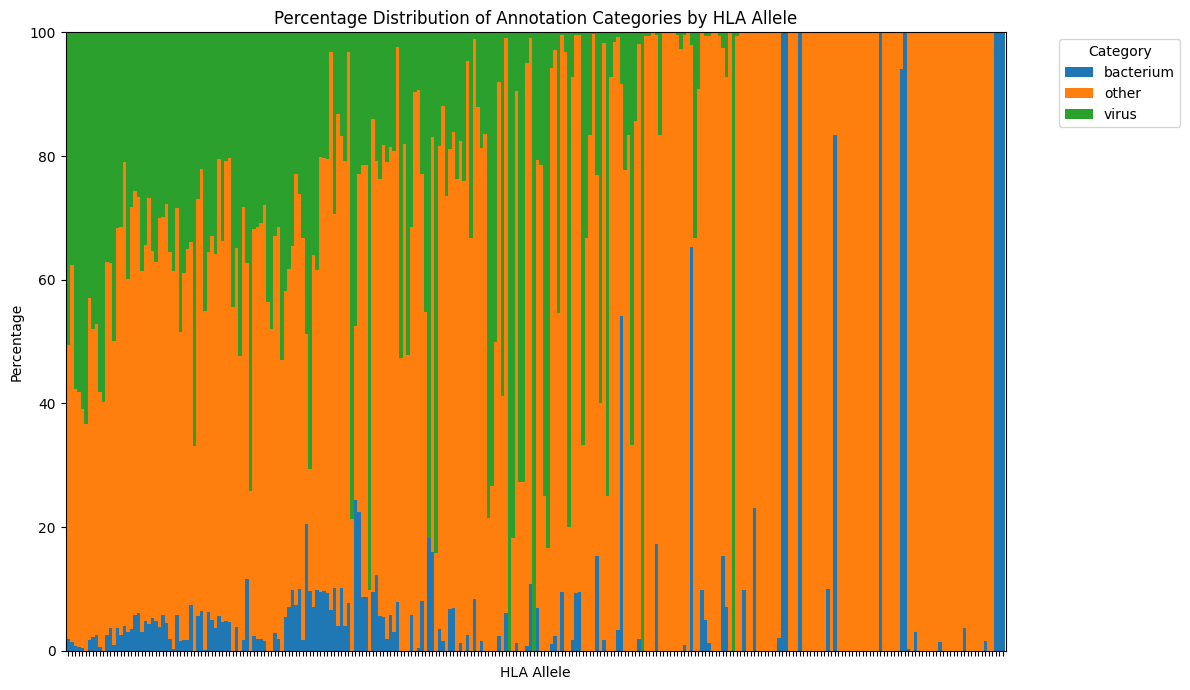

In [26]:
import matplotlib.pyplot as plt

# Remove columns where the sum of counts (across all categories) is zero
aggregated_table_filtered = aggregated_table.loc[:, aggregated_table.sum(axis=0) != 0]

# Convert counts to percentages per HLA allele (per column)
percent_table = aggregated_table_filtered.div(aggregated_table_filtered.sum(axis=0), axis=1) * 100

# Create the stacked bar graph with width=1 (removes gaps between bars)
fig, ax = plt.subplots(figsize=(12, 7))
percent_table.T.plot(kind='bar', stacked=True, ax=ax, width=1)

# Remove borders between bar segments
for patch in ax.patches:
    patch.set_linewidth(0)
    patch.set_edgecolor('none')

# Set axis labels and title
ax.set_xlabel("HLA Allele")
ax.set_ylabel("Percentage")
ax.set_title("Percentage Distribution of Annotation Categories by HLA Allele")
ax.set_ylim(0, 100)
ax.set_xticklabels([])

# Position the legend outside of the plot area
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [31]:
aggregated_table.describe()

,HLAA0201,HLADRB10101,HLAA6802,HLAA0203,HLAA0206,HLAA0202,HLAA0301,HLAA1101,HLAA3101,HLAA6801,...,HLADQB10202,HLADR52,HLAB2710,HLAA1102,HLADPB10101,HLAA6812,HLADQA10505DQB10301,HLADR17,HLADR8,HLADRB11503
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,4829.333333,3021.666667,1915.333333,1865.000000,1676.333333,1464.333333,2087.666667,1850.000000,1579.666667,1009.333333,...,34.000000,3.333333,0.666667,4.666667,41.666667,5.000000,0.333333,7.000000,12.666667,0.666667
std,3951.053066,2714.289287,1687.701790,1654.710851,1541.034177,1396.787147,1752.257211,1500.116995,1262.727339,894.215485,...,58.889727,5.773503,1.154701,8.082904,70.443831,8.660254,0.577350,12.124356,21.939310,1.154701
min,274.000000,131.000000,40.000000,33.000000,19.000000,0.000000,113.000000,119.000000,124.000000,20.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3581.500000,1774.500000,1217.000000,1172.000000,981.500000,805.500000,1403.000000,1389.500000,1179.500000,634.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6889.000000,3418.000000,2394.000000,2311.000000,1944.000000,1611.000000,2693.000000,2660.000000,2235.000000,1248.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7107.000000,4467.000000,2853.000000,2781.000000,2505.000000,2196.500000,3075.000000,2715.500000,2307.500000,1504.000000,...,51.000000,5.000000,1.000000,7.000000,62.500000,7.500000,0.500000,10.500000,19.000000,1.000000
max,7325.000000,5516.000000,3312.000000,3251.000000,3066.000000,2782.000000,3457.000000,2771.000000,2380.000000,1760.000000,...,102.000000,10.000000,2.000000,14.000000,123.000000,15.000000,1.000000,21.000000,38.000000,2.000000
